# Topic-Analyse mit Topic-Modelling

In [13]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

Neben dem Ansatz mit verschiedenen Stichwörtern sollen die Inhalte außerdem mit dem bekannten Topic Modeling Algorithmus `BERTopic` untersucht und veranschaulicht werden. Dazu wird wie gewohnt zunächst die `csv`-Datei mit den benötigten Daten importiert:

In [19]:
articles_data = pd.read_csv('2-4-data-extended-keywords-sentiment.csv')
articles = pd.DataFrame(articles_data)
articles.head()

date      time category  \
0  2024-05-10  17:14:00  politik   
1  2024-05-10  17:16:00  politik   
2  2024-05-10  19:33:00  politik   
3  2024-05-10  08:40:00  politik   
4  2024-05-10  15:44:00  politik   

                                            headline  \
0   Gruppen treten am Vatertag mit Nazi Symbolik auf   
1  Peking schimpft ueber US Zerstoerer im Suedchi...   
2  SPD Politiker Ecke schildert Sekunden der Prue...   
3  Landkreise fordern haertere Buergergeld Sankti...   
4  Buschmanns Regierungsflieger kehrt in Parkposi...   

                                                text               upload  \
0  Am Vatertag steuern Männer ein altes Militärfa...  2024-05-10 17:14:00   
1  China beansprucht die Paracel-Inseln im Südchi...  2024-05-10 17:16:00   
2  Der vor einer Woche brutal attackierte SPD-Pol...  2024-05-10 19:33:00   
3  Beim Bürgergeld in seiner jetzigen Form bemäng...  2024-05-10 08:40:00   
4  Deutsche Regierungsflieger sind für ihre Panne...  2024-05-10 15:44:00   

   upload-hour weekday  length  \
0           17  Friday    2908   
1           17  Friday    3504   
2           19  Friday    2445   
3            8  Friday    2984   
4           15  Friday    2570   

                                            keywords sentiment_headline  \
0  Politik, Gesellschaft, Extremismus, Rechtsextr...            neutral   
1  China, USA, Paracel-Inseln, Südchinesisches Me...           negative   
2  Politik, Gewalt gegen Politiker, SPD, Wahlkamp...           negative   
3  Bürgergeld, Landkreistag, Vermögensregelungen,...            neutral   
4  Regierungsflugzeug, Technikproblem, Verzögerun...            neutral   

  sentiment_text  sentiment_prob_headline_positive  \
0        neutral                          0.000229   
1        neutral                          0.026734   
2       negative                          0.005901   
3        neutral                          0.000009   
4       negative                          0.000084   

   sentiment_prob_headline_negative  sentiment_prob_headline_neutral  \
0                          0.000604                         0.999167   
1                          0.750409                         0.222857   
2                          0.979033                         0.015065   
3                          0.000026                         0.999965   
4                          0.000253                         0.999663   

   sentiment_prob_text_positive  sentiment_prob_text_negative  \
0                      0.001950                      0.010997   
1                      0.002821                      0.010704   
2                      0.019161                      0.757548   
3                      0.002032                      0.010209   
4                      0.012173                      0.830547   

   sentiment_prob_text_neutral  
0                     0.987053  
1                     0.986475  
2                     0.223291  
3                     0.987759  
4                     0.157280

## Textvorbereitung

Bevor Texte mit Algorithmen wie `BERTopic` analysiert werden, sollten sie vorverarbeitet werden. Dazu zählt beispielsweise das Entfernen von Stoppwörtern, da diese ansonsten eventuell eigene Kategorien erhalten können. Dafür wird die Bibliothek `nltk` verwendet, die entsprechende Datensätze zur Verfügung stellt. Außerdem werden Wörter auf ihren Wortstamm reduziert, was die Textmenge reduziert und dabei hilft gleiche Wörter unabhängig ihrer Konjunktion auch als solche zu erkennen.

In [25]:
stemmer = SnowballStemmer('german')
stop_words = set(stopwords.words('german'))

In [26]:
def preprocess_text_nltk(text):
    text = text.lower()
    tokens = word_tokenize(text, language='german')
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

Die vorverarbeiteten Texte werden in einer neuen Spalte `processed_text` gespeichert.

In [27]:
articles['processed_text'] = articles['text'].apply(preprocess_text_nltk)
articles.head()

date      time category  \
0  2024-05-10  17:14:00  politik   
1  2024-05-10  17:16:00  politik   
2  2024-05-10  19:33:00  politik   
3  2024-05-10  08:40:00  politik   
4  2024-05-10  15:44:00  politik   

                                            headline  \
0   Gruppen treten am Vatertag mit Nazi Symbolik auf   
1  Peking schimpft ueber US Zerstoerer im Suedchi...   
2  SPD Politiker Ecke schildert Sekunden der Prue...   
3  Landkreise fordern haertere Buergergeld Sankti...   
4  Buschmanns Regierungsflieger kehrt in Parkposi...   

                                                text               upload  \
0  Am Vatertag steuern Männer ein altes Militärfa...  2024-05-10 17:14:00   
1  China beansprucht die Paracel-Inseln im Südchi...  2024-05-10 17:16:00   
2  Der vor einer Woche brutal attackierte SPD-Pol...  2024-05-10 19:33:00   
3  Beim Bürgergeld in seiner jetzigen Form bemäng...  2024-05-10 08:40:00   
4  Deutsche Regierungsflieger sind für ihre Panne...  2024-05-10 15:44:00   

   upload-hour weekday  length  \
0           17  Friday    2908   
1           17  Friday    3504   
2           19  Friday    2445   
3            8  Friday    2984   
4           15  Friday    2570   

                                            keywords sentiment_headline  \
0  Politik, Gesellschaft, Extremismus, Rechtsextr...            neutral   
1  China, USA, Paracel-Inseln, Südchinesisches Me...           negative   
2  Politik, Gewalt gegen Politiker, SPD, Wahlkamp...           negative   
3  Bürgergeld, Landkreistag, Vermögensregelungen,...            neutral   
4  Regierungsflugzeug, Technikproblem, Verzögerun...            neutral   

  sentiment_text  sentiment_prob_headline_positive  \
0        neutral                          0.000229   
1        neutral                          0.026734   
2       negative                          0.005901   
3        neutral                          0.000009   
4       negative                          0.000084   

   sentiment_prob_headline_negative  sentiment_prob_headline_neutral  \
0                          0.000604                         0.999167   
1                          0.750409                         0.222857   
2                          0.979033                         0.015065   
3                          0.000026                         0.999965   
4                          0.000253                         0.999663   

   sentiment_prob_text_positive  sentiment_prob_text_negative  \
0                      0.001950                      0.010997   
1                      0.002821                      0.010704   
2                      0.019161                      0.757548   
3                      0.002032                      0.010209   
4                      0.012173                      0.830547   

   sentiment_prob_text_neutral  \
0                     0.987053   
1                     0.986475   
2                     0.223291   
3                     0.987759   
4                     0.157280   

                                      processed_text  
0  vatertag steu mann alt militarfahrzeug reichsf...  
1  china beansprucht sudchines meer nah umstritt ...  
2  woch brutal attackiert matthias eck schildert ...  
3  beim burgergeld jetzig form bemangeln vertret ...  
4  deutsch regierungsflieg pannenanfall bekannt v...

## Topic Modeling

Nun kann das Topic Modeling mit `BERTopic` durchgeführt werden. Dazu wird ein neues `topic_model` erstellt und diesem über die `fit_transform`-Funktion die Dokumente bzw. die Artikeltexte übergeben. Für jeden Artikel wird anschließend im DataFrame die von Bertopic ermittelte Kategorie angefügt. 

In [55]:
documents = articles['processed_text'].tolist()
topic_model = BERTopic(language="multilingual")
topics, probs = topic_model.fit_transform(documents)
articles['topic'] = topics
articles.head()

date      time category  \
0  2024-05-10  17:14:00  politik   
1  2024-05-10  17:16:00  politik   
2  2024-05-10  19:33:00  politik   
3  2024-05-10  08:40:00  politik   
4  2024-05-10  15:44:00  politik   

                                            headline  \
0   Gruppen treten am Vatertag mit Nazi Symbolik auf   
1  Peking schimpft ueber US Zerstoerer im Suedchi...   
2  SPD Politiker Ecke schildert Sekunden der Prue...   
3  Landkreise fordern haertere Buergergeld Sankti...   
4  Buschmanns Regierungsflieger kehrt in Parkposi...   

                                                text               upload  \
0  Am Vatertag steuern Männer ein altes Militärfa...  2024-05-10 17:14:00   
1  China beansprucht die Paracel-Inseln im Südchi...  2024-05-10 17:16:00   
2  Der vor einer Woche brutal attackierte SPD-Pol...  2024-05-10 19:33:00   
3  Beim Bürgergeld in seiner jetzigen Form bemäng...  2024-05-10 08:40:00   
4  Deutsche Regierungsflieger sind für ihre Panne...  2024-05-10 15:44:00   

   upload-hour weekday  length  \
0           17  Friday    2908   
1           17  Friday    3504   
2           19  Friday    2445   
3            8  Friday    2984   
4           15  Friday    2570   

                                            keywords sentiment_headline  \
0  Politik, Gesellschaft, Extremismus, Rechtsextr...            neutral   
1  China, USA, Paracel-Inseln, Südchinesisches Me...           negative   
2  Politik, Gewalt gegen Politiker, SPD, Wahlkamp...           negative   
3  Bürgergeld, Landkreistag, Vermögensregelungen,...            neutral   
4  Regierungsflugzeug, Technikproblem, Verzögerun...            neutral   

  sentiment_text  sentiment_prob_headline_positive  \
0        neutral                          0.000229   
1        neutral                          0.026734   
2       negative                          0.005901   
3        neutral                          0.000009   
4       negative                          0.000084   

   sentiment_prob_headline_negative  sentiment_prob_headline_neutral  \
0                          0.000604                         0.999167   
1                          0.750409                         0.222857   
2                          0.979033                         0.015065   
3                          0.000026                         0.999965   
4                          0.000253                         0.999663   

   sentiment_prob_text_positive  sentiment_prob_text_negative  \
0                      0.001950                      0.010997   
1                      0.002821                      0.010704   
2                      0.019161                      0.757548   
3                      0.002032                      0.010209   
4                      0.012173                      0.830547   

   sentiment_prob_text_neutral  \
0                     0.987053   
1                     0.986475   
2                     0.223291   
3                     0.987759   
4                     0.157280   

                                      processed_text  topic  
0  vatertag steu mann alt militarfahrzeug reichsf...     -1  
1  china beansprucht sudchines meer nah umstritt ...      8  
2  woch brutal attackiert matthias eck schildert ...     -1  
3  beim burgergeld jetzig form bemangeln vertret ...     -1  
4  deutsch regierungsflieg pannenanfall bekannt v...     -1

Zur Veranschaulich der Verteilung der Themen wird eine Funktion definiert:

In [56]:
def visualize_topic_distribution(articles, topic_column_name):
    topic_counts = articles[topic_column_name].value_counts()
    plt.figure(figsize=(30, 6))
    topic_counts.plot(kind='bar', color='skyblue')
    plt.xlabel('Topic')
    plt.ylabel('Count of articles')
    plt.title('Distribution of topics')
    plt.xticks(ticks=range(len(topic_counts)), labels=[f'{i}' for i in topic_counts.index], rotation=45)
    plt.show()

Der nachfolgende Graph zeigt die Verteilung der Topics. Wie man sehen kann, fällt ein Großteil der Artikel, ungefährt die Hälfe, unter die Kategorie `-1`. Dieser Kategorie ordnet `BERTopic` alle `Outlier` zu, also Ausreißer zu, die keiner Kategorie zugeordnet werden konnten.

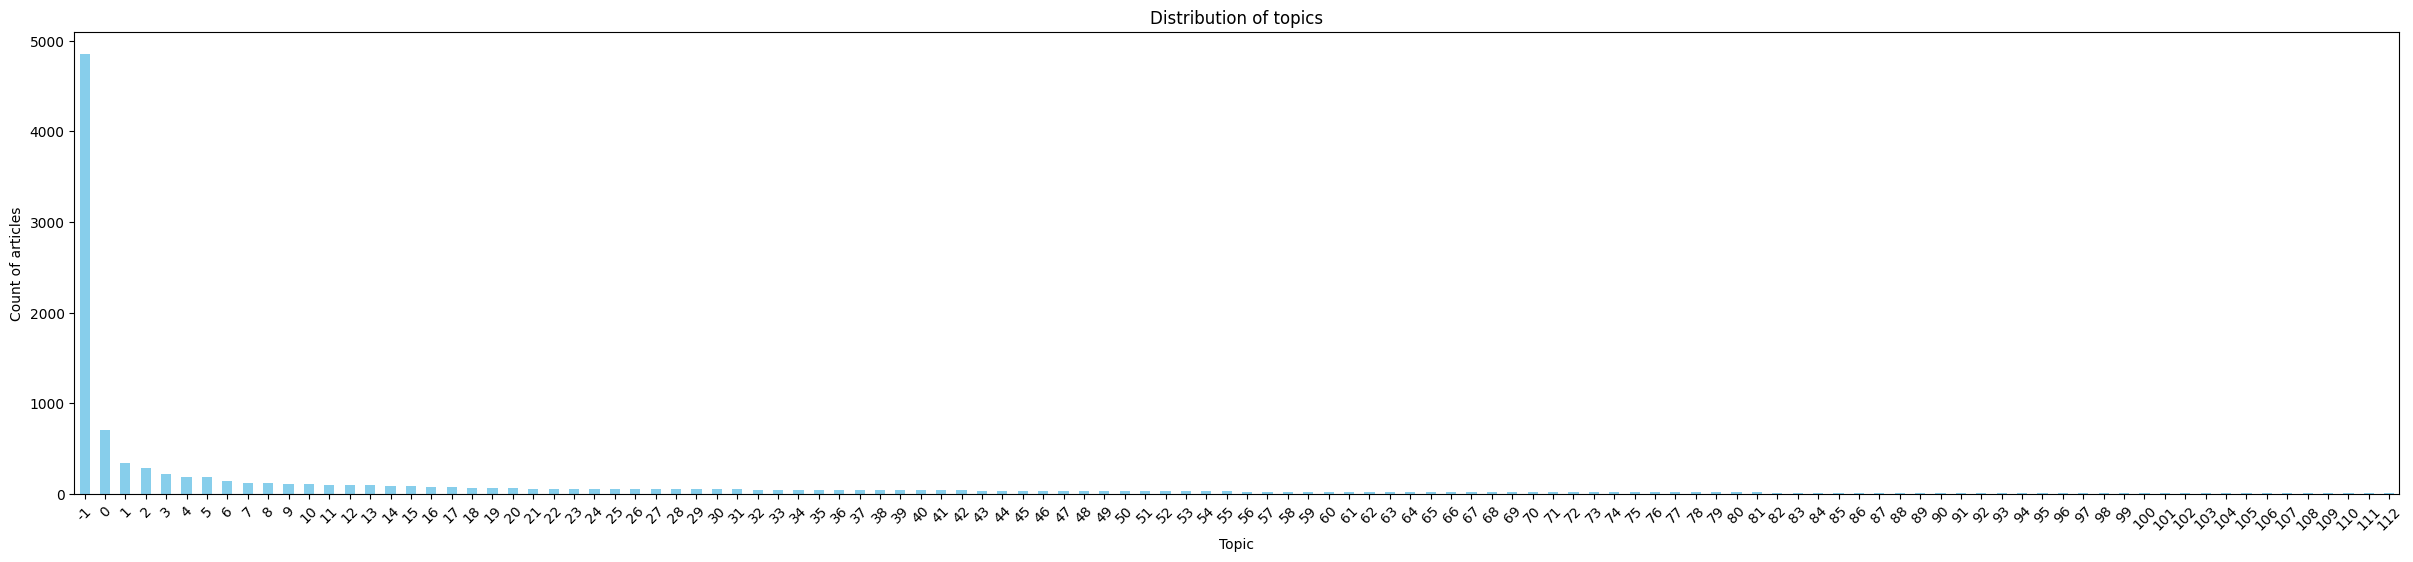

In [57]:
visualize_topic_distribution(articles, "topic")

Dieses Problem zeigt sich ebenfalls in der von `BERTopic` generierten Darstellung. Alle grauen Punkte stellen die Ausreißer dar.

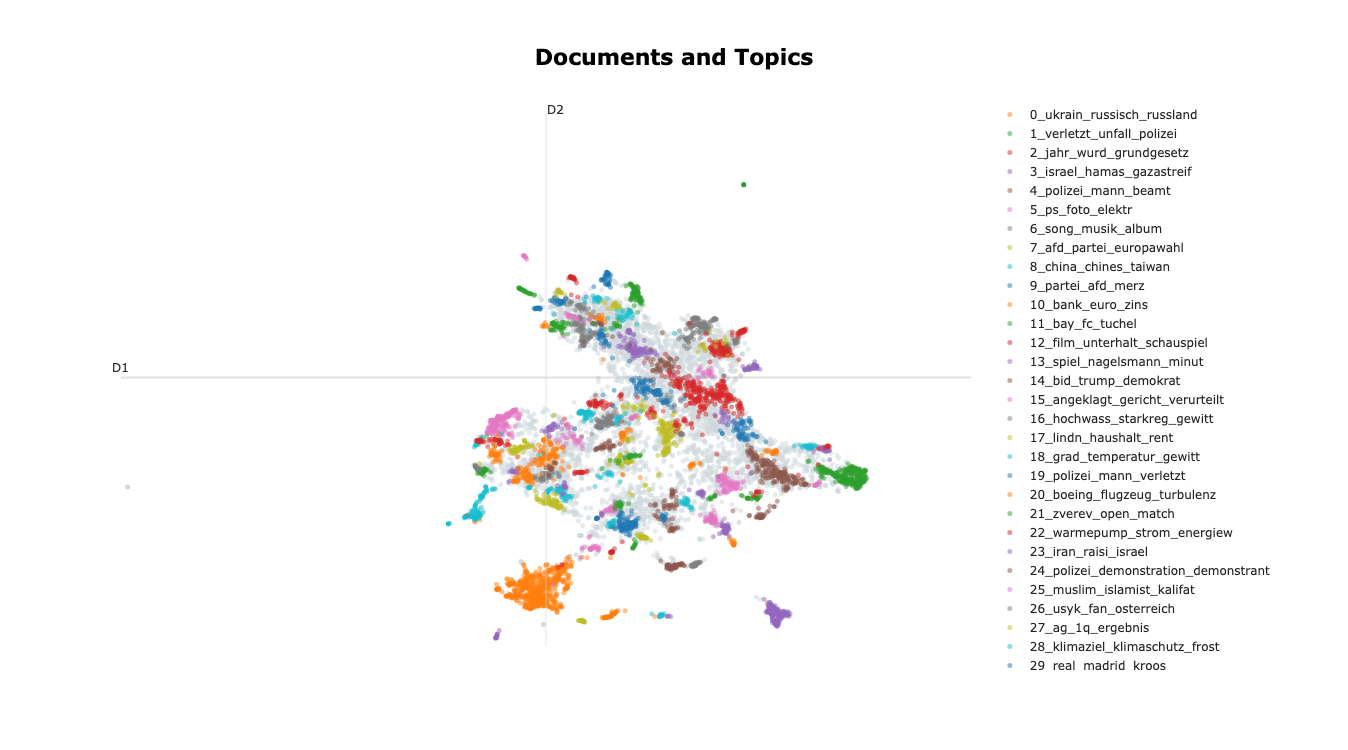

In [58]:
topic_model.visualize_documents(documents, hide_document_hover=True, hide_annotations=True)

Ein weiteres Problem stellt die Menge an gefunden Topics mit 100+ verschiedenen Themen dar. Für beide Problemen bietet `BERTopic` jedoch Lösungen. Die Menge an Kategorien kann jedoch über entsprechende Funktionsargumente selbstständig angepasst werden. Im Folgenden wird die Anzahl an Topics auf 70 gesetzt, um die Menge an Themen leicht einzugrenzen und Topics, die nur äußerst selten auftreten nicht zu berücksichtigen.

In [59]:
documents = articles['processed_text'].tolist()
topic_model = BERTopic(language="multilingual", nr_topics=70)
topics, probs = topic_model.fit_transform(documents)
articles['topic'] = topics
articles.head()

date      time category  \
0  2024-05-10  17:14:00  politik   
1  2024-05-10  17:16:00  politik   
2  2024-05-10  19:33:00  politik   
3  2024-05-10  08:40:00  politik   
4  2024-05-10  15:44:00  politik   

                                            headline  \
0   Gruppen treten am Vatertag mit Nazi Symbolik auf   
1  Peking schimpft ueber US Zerstoerer im Suedchi...   
2  SPD Politiker Ecke schildert Sekunden der Prue...   
3  Landkreise fordern haertere Buergergeld Sankti...   
4  Buschmanns Regierungsflieger kehrt in Parkposi...   

                                                text               upload  \
0  Am Vatertag steuern Männer ein altes Militärfa...  2024-05-10 17:14:00   
1  China beansprucht die Paracel-Inseln im Südchi...  2024-05-10 17:16:00   
2  Der vor einer Woche brutal attackierte SPD-Pol...  2024-05-10 19:33:00   
3  Beim Bürgergeld in seiner jetzigen Form bemäng...  2024-05-10 08:40:00   
4  Deutsche Regierungsflieger sind für ihre Panne...  2024-05-10 15:44:00   

   upload-hour weekday  length  \
0           17  Friday    2908   
1           17  Friday    3504   
2           19  Friday    2445   
3            8  Friday    2984   
4           15  Friday    2570   

                                            keywords sentiment_headline  \
0  Politik, Gesellschaft, Extremismus, Rechtsextr...            neutral   
1  China, USA, Paracel-Inseln, Südchinesisches Me...           negative   
2  Politik, Gewalt gegen Politiker, SPD, Wahlkamp...           negative   
3  Bürgergeld, Landkreistag, Vermögensregelungen,...            neutral   
4  Regierungsflugzeug, Technikproblem, Verzögerun...            neutral   

  sentiment_text  sentiment_prob_headline_positive  \
0        neutral                          0.000229   
1        neutral                          0.026734   
2       negative                          0.005901   
3        neutral                          0.000009   
4       negative                          0.000084   

   sentiment_prob_headline_negative  sentiment_prob_headline_neutral  \
0                          0.000604                         0.999167   
1                          0.750409                         0.222857   
2                          0.979033                         0.015065   
3                          0.000026                         0.999965   
4                          0.000253                         0.999663   

   sentiment_prob_text_positive  sentiment_prob_text_negative  \
0                      0.001950                      0.010997   
1                      0.002821                      0.010704   
2                      0.019161                      0.757548   
3                      0.002032                      0.010209   
4                      0.012173                      0.830547   

   sentiment_prob_text_neutral  \
0                     0.987053   
1                     0.986475   
2                     0.223291   
3                     0.987759   
4                     0.157280   

                                      processed_text  topic  
0  vatertag steu mann alt militarfahrzeug reichsf...     -1  
1  china beansprucht sudchines meer nah umstritt ...     20  
2  woch brutal attackiert matthias eck schildert ...     -1  
3  beim burgergeld jetzig form bemangeln vertret ...     12  
4  deutsch regierungsflieg pannenanfall bekannt v...     -1

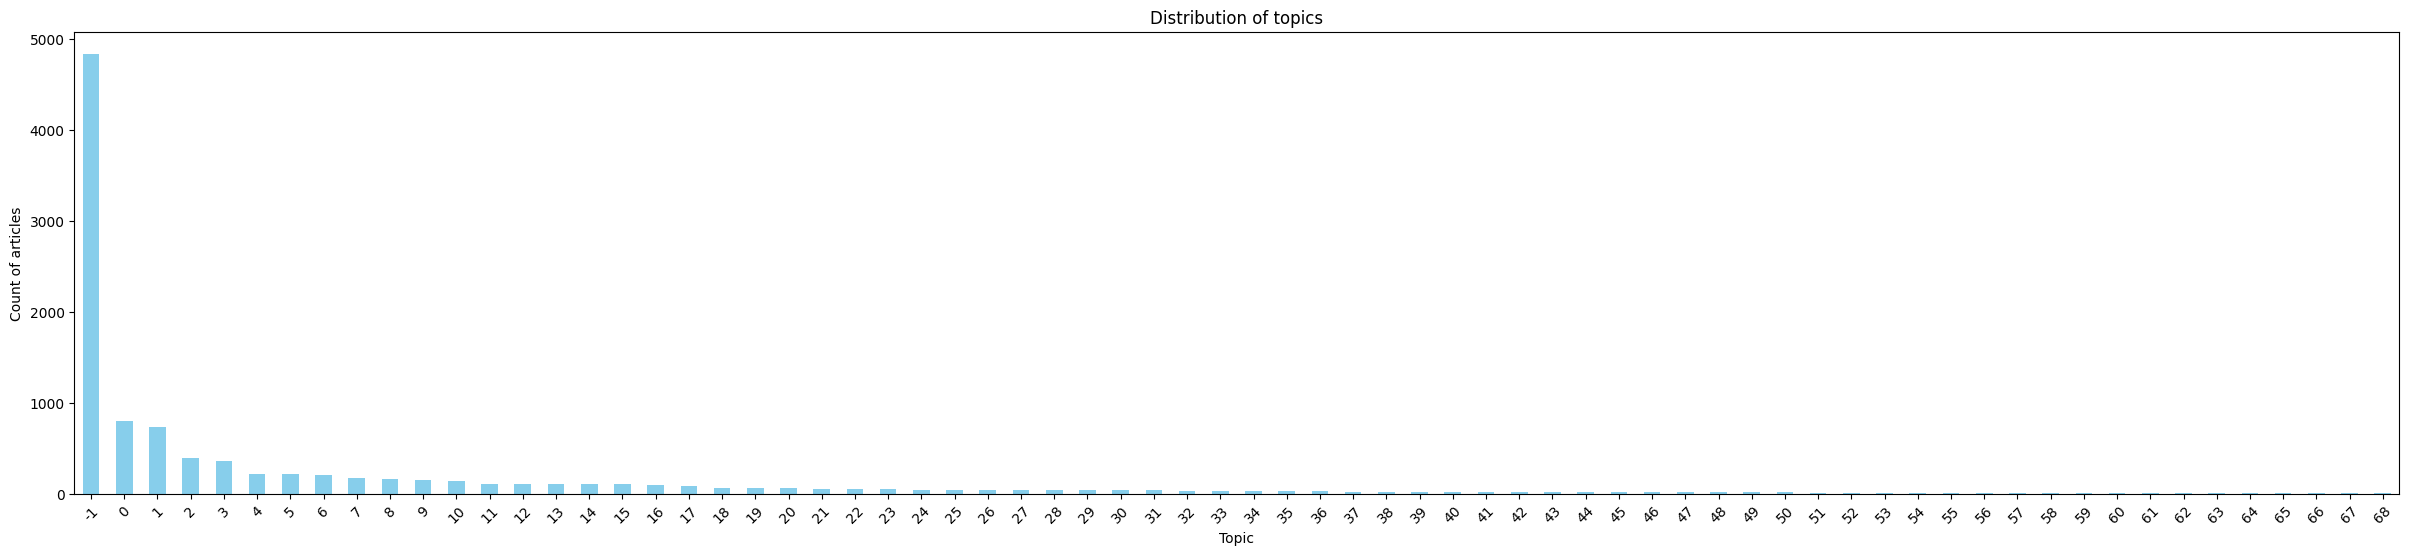

In [62]:
visualize_topic_distribution(articles, "topic")

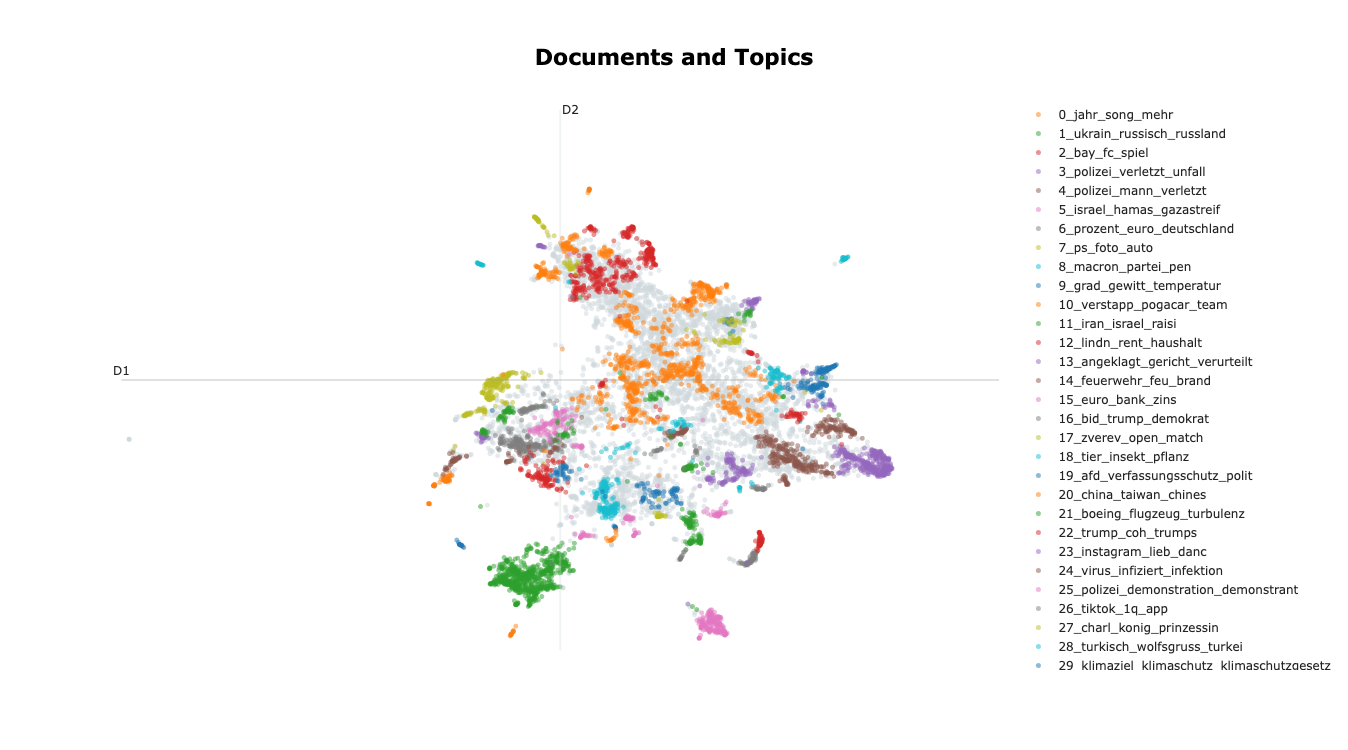

In [61]:
topic_model.visualize_documents(documents, hide_document_hover=True, hide_annotations=True)

Als nächstes sollen die Ausreißer noch eingegrenzt werden. `BERTopic` stellt dafür mehrere Strategien zur Verfügung. Hier verwendet wird die automatische Reduzierung durch `BERTopic` über die Funktion `topic_model.reduce_outliers(documents, topics)`. Diese werden in der neuen Spalte `new_topics` gespeichert.

In [64]:
articles['new_topic'] = topic_model.reduce_outliers(documents, topics)

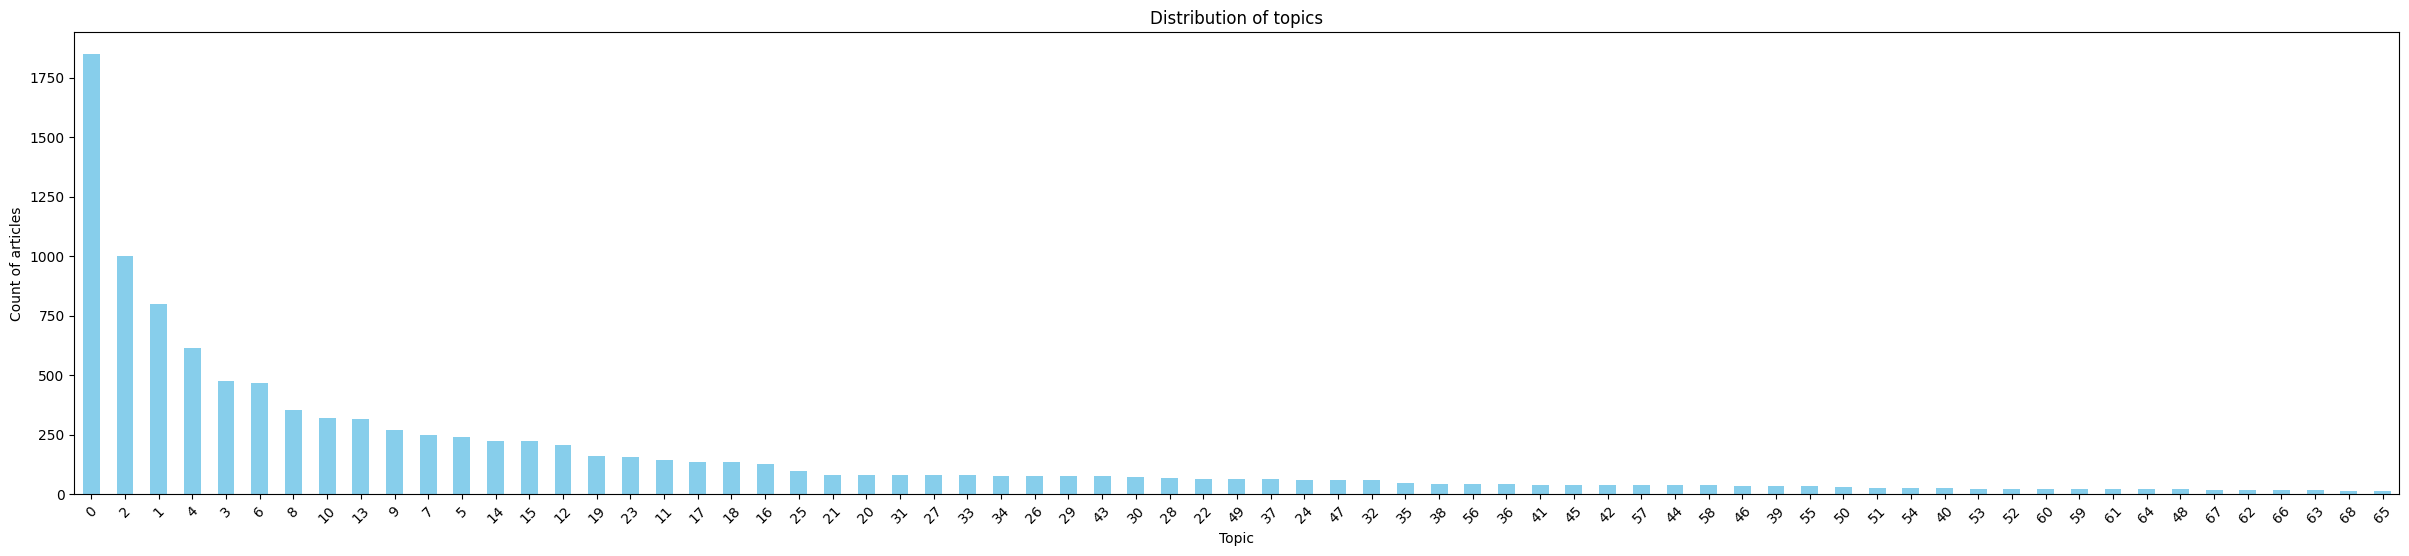

In [65]:
visualize_topic_distribution(articles, "new_topic")

Wie zu sehen ist, konnte eine Vielzahl an Ausreißern andern Topics zugeordnet werden. Die erweiterten Kategorien können ebenso im Cluster-Diagram angezeigt werden.

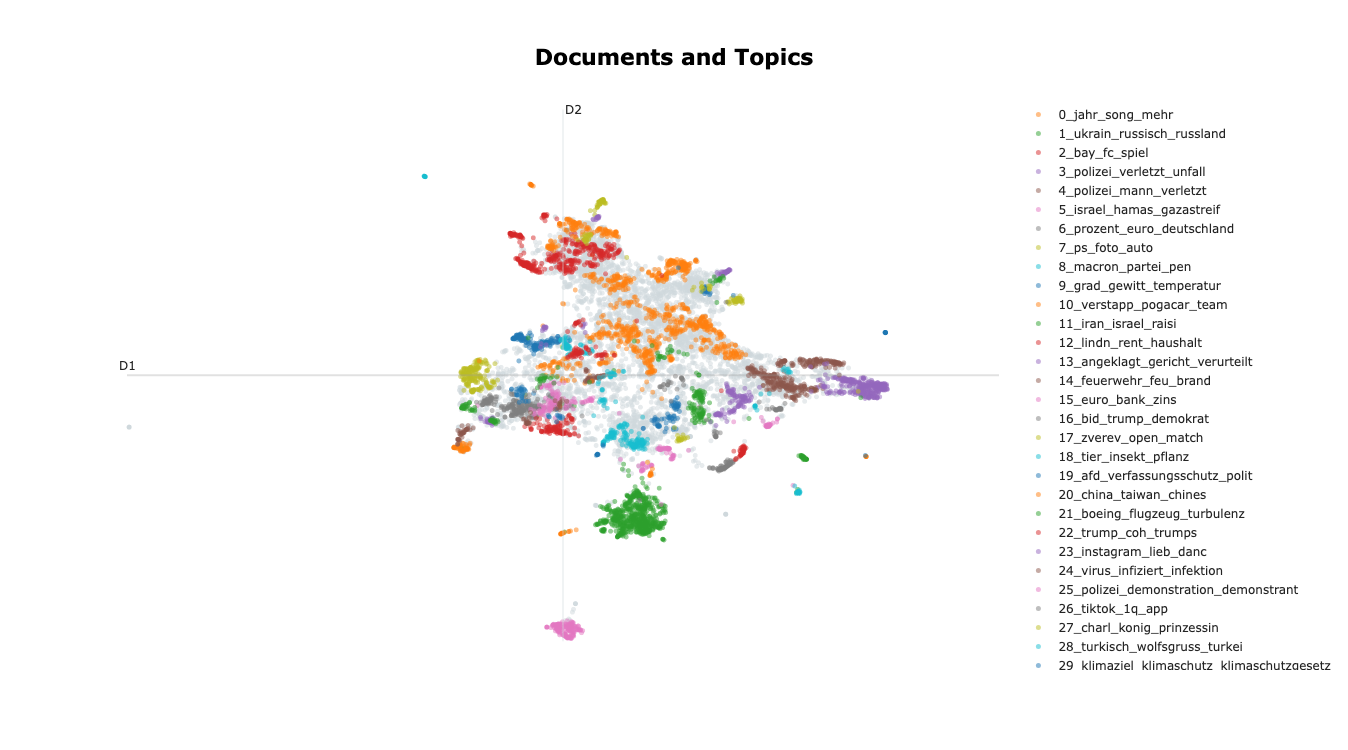

In [66]:
topic_model.visualize_documents(documents, hide_document_hover=True, hide_annotations=True)

Auch diese Übersicht stellt eine gute Visualisierung zu den Themenschwerpunkten von `n-tv` dar.

Eine weitere von `BERTopic` zur Verfügung gestellte Visualiserung stellt ebenfalls gut die Themen dar:

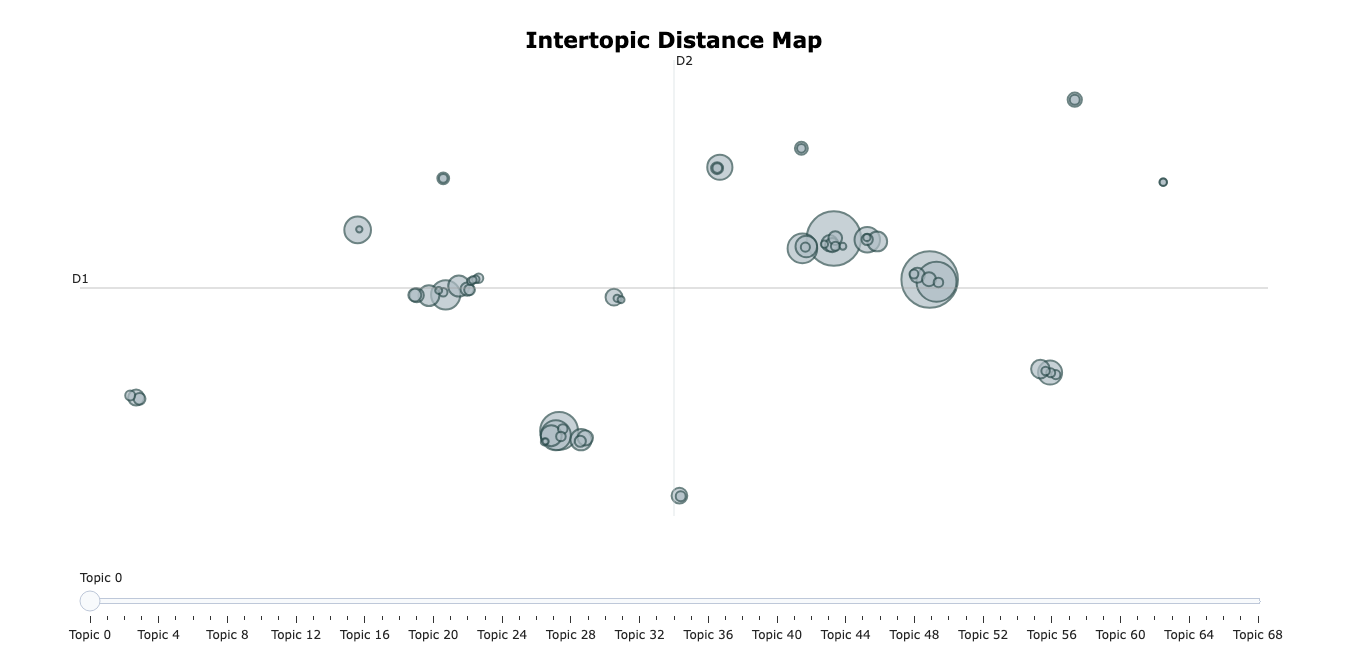

In [70]:
topic_model.visualize_topics()

Um ähnliche Themen zu finden, kann `BERTopic` eine Heatmap generieren, die den Abstand zwei Kategorien zueinander anzeigt.

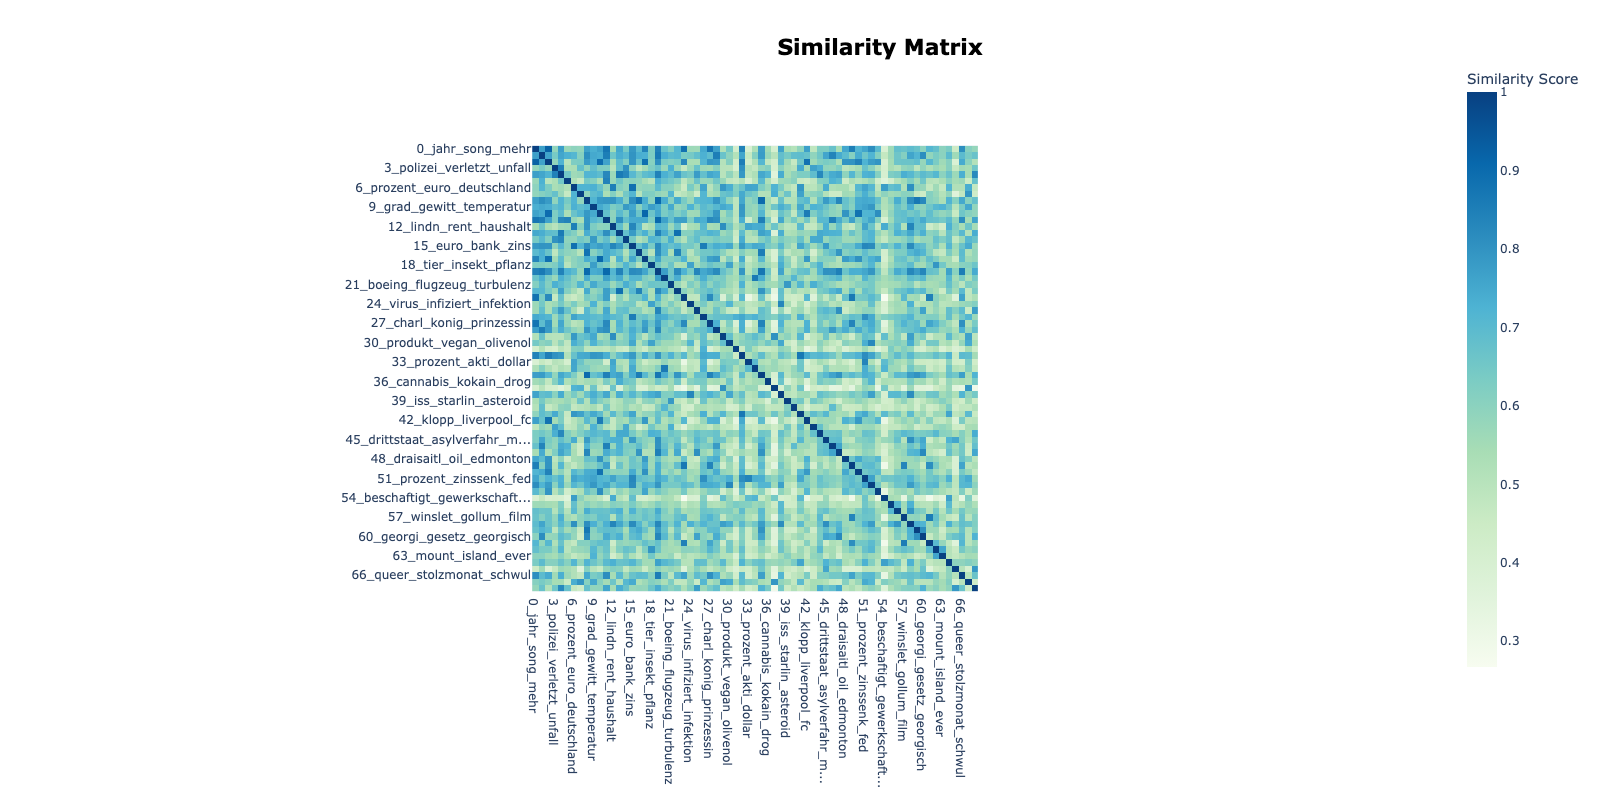

In [68]:
topic_model.visualize_heatmap()

Die gefunden Kategorien können mit Hilfe von `BERTopic` zusätzlich den Kategorien zugeordnet werden bzw. kann visualisert werden, welche Themen in welchen Kategorien besonders stark auftreten.

In [72]:
topics_per_class = topic_model.topics_per_class(documents, classes=articles["category"])

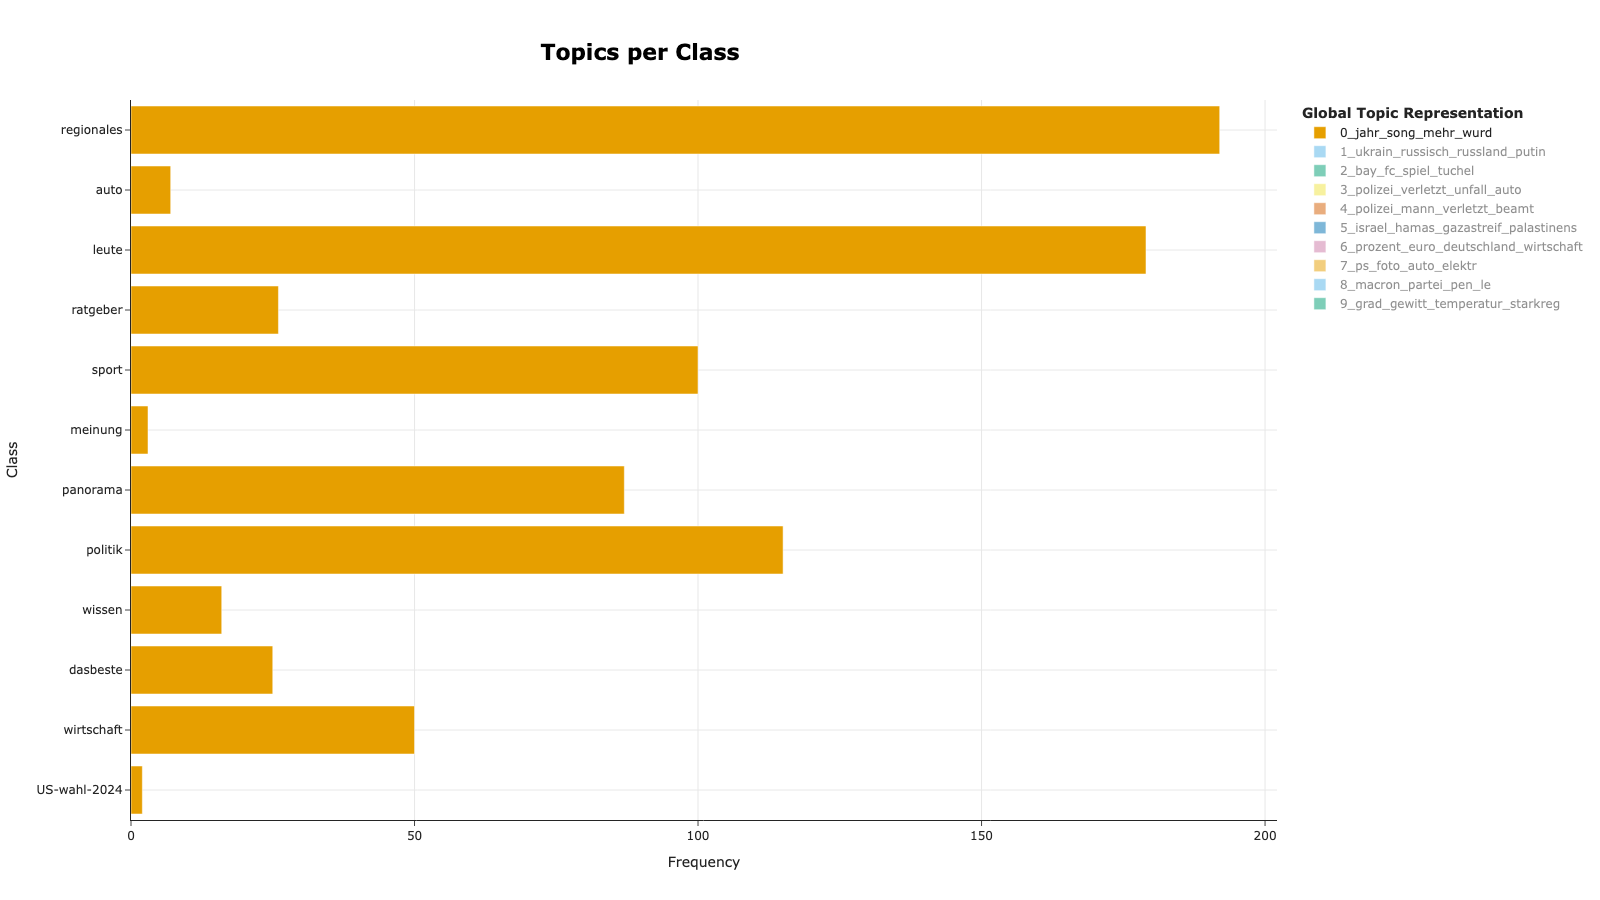

In [74]:
topic_model.visualize_topics_per_class(topics_per_class)

Darstellung der Verteilung der Wörter pro Kategorie:

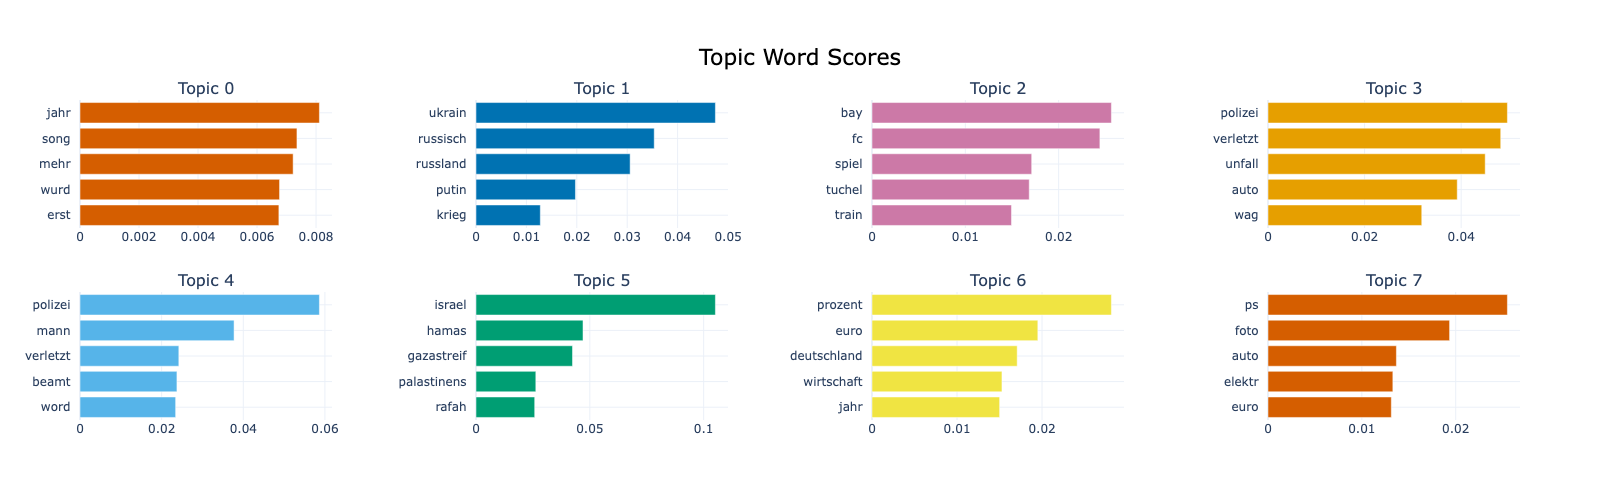

In [75]:
topic_model.visualize_barchart()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 332.92it/s]


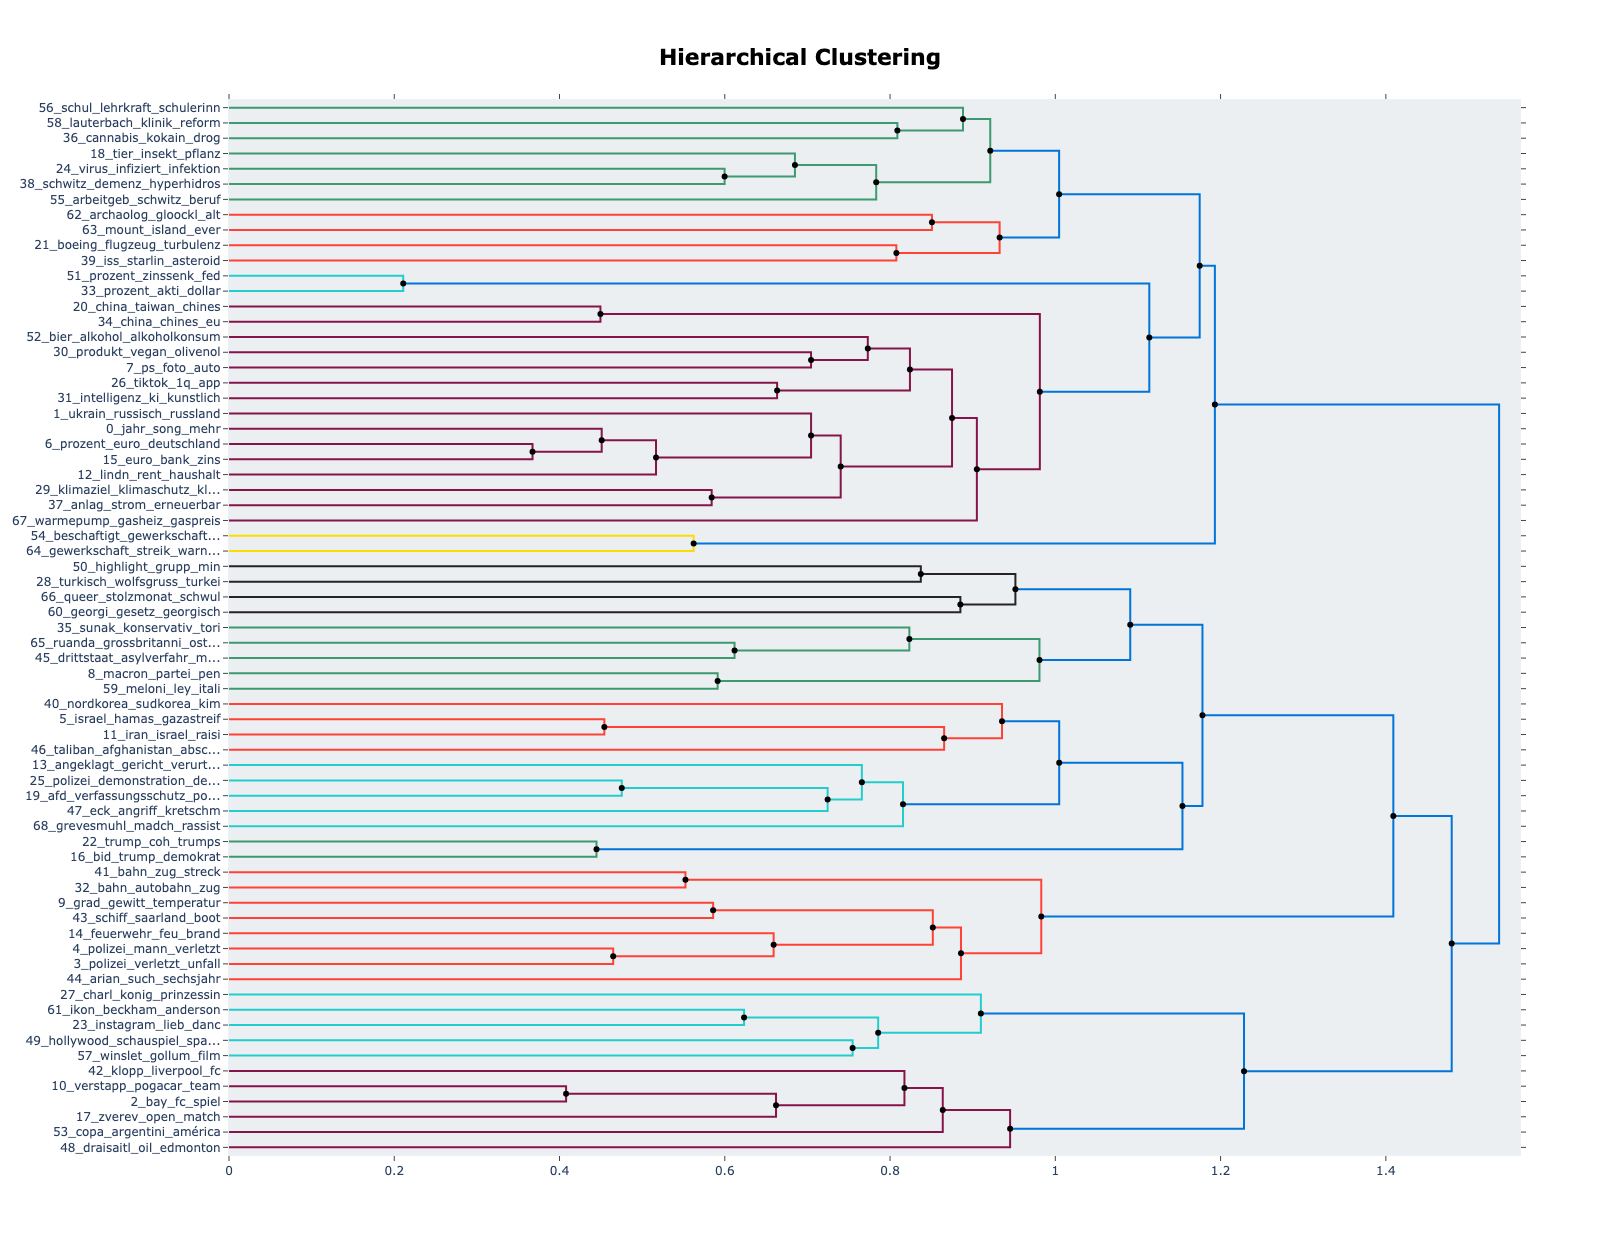

In [77]:
hierarchical_topics = topic_model.hierarchical_topics(documents)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)